# Analysis of MITgcm llc4320 model output in the Tropical Pacific

### Rocha, Gille, Conuelle, and Chereskin

Scripps Institution of Oceanography, UC San Diego

In [33]:
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

sys.path.insert(0, '../../')
import TropicalPacific_params as TPparams
import TropicalPacific_map as TPmap
import TropicalPacific_tools as TPtools

from pyspec import spectrum as spec
reload(spec)

<module 'pyspec.spectrum' from '/Users/crocha/Dropbox/research/pyspec/pyspec/spectrum.pyc'>

In [34]:
grid_path = '../grid/'
dd = 5.

In [35]:
llc4320 = TPparams.LLC4320(grid_path=grid_path)
llc4320map = TPmap.map(lonmin = llc4320.xg.min()-dd,lonmax = llc4320.xg.max()+dd,
                       latmin = llc4320.yg.min()-dd,latmax = llc4320.yg.max()+dd)

# The region

The region of study is the Tropical South Pacific. The regional limits  roughtly match on the [animation](http://www-pord.ucsd.edu/~sgille/cryosat-2_animated_modes_mask-world.gif) that shows the Cryosat-SAR mode sampling (see magenta lines in the map below). The llc4320 output spans roughly $4.5$ months starting in September 2011. The model data are available hourly.

In [36]:
xg_region = np.hstack([llc4320.xg[0,0],llc4320.xg[0,-1],
                          llc4320.xg[-1,-1],llc4320.xg[-1,0],
                          llc4320.xg[0,0]])

yg_region = np.hstack([llc4320.yg[0,0],llc4320.yg[0,-1],
                          llc4320.yg[-1,-1],llc4320.yg[-1,0],
                          llc4320.yg[0,0],])

xg_subregion = np.hstack([-125.,-105,-105,-125,-125])
yg_subregion = np.hstack([-25.,-25,-5,-5,-25])

xg_region, yg_region = llc4320map.m(xg_region,yg_region)
xg_subregion, yg_subregion = llc4320map.m(xg_subregion,yg_subregion)

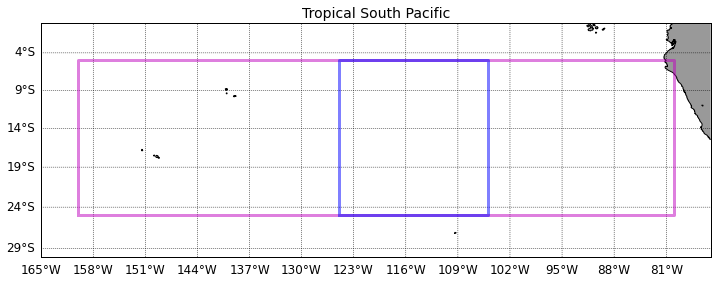

In [37]:
fig = plt.figure(facecolor='w', figsize=(12.,8.5))

llc4320map.m.fillcontinents(color='.60',lake_color='none')
llc4320map.draw_par_mer()
llc4320map.m.drawcoastlines()

llc4320map.m.plot(xg_region,yg_region,'m',linewidth=3.,alpha=.5)
llc4320map.m.plot(xg_subregion,yg_subregion,'b',linewidth=3.,alpha=.5)

plt.title('Tropical South Pacific')

# SSH variance frequency spectra

In [38]:
spec_wv_freq = np.load('eta_var_wavenumber_freq_spec.npz')

In [39]:
nl,nk,nomg = spec_wv_freq['Eeta'].shape
dl, dk, domg = spec_wv_freq['l'][nl/2+1],spec_wv_freq['k'][nk/2+1], spec_wv_freq['omg'][0]

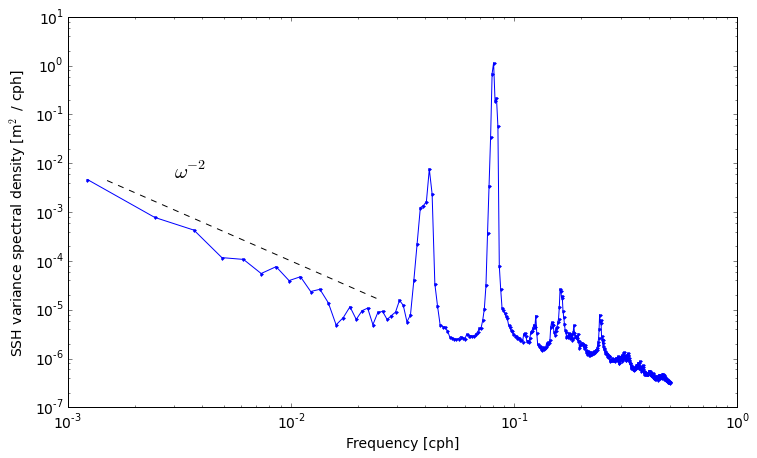

In [40]:
fi = np.array([1.5e-3,.25e-1])

plt.figure(figsize=(12,7))

plt.loglog(spec_wv_freq['omg'],spec_wv_freq['Eeta'].sum(axis=(0,1))*dk*dl,'.-')
#plt.loglog(fd,Ed,'r.-')

plt.loglog(fi,fi**-2/1.e8,'k--')
plt.text(3.e-3,.5e-2,r'$\omega^{-2}$',fontsize=20)

plt.ylabel('SSH variance spectral density [m$^2$ / cph]')
plt.xlabel('Frequency [cph]')

# Wavenumber spectra

The two-dimensional spectrum is fairly isotropic. The hourly fields show some quantization associated with these high-frequency modes.

Integrating the spectra azimuthally, we obtain the radial wavenumber spectrum of SSH variance. Clearly, most of the high-frequency variability projects onto  large scales ($> 500$ km), but there is also significant high-frequency variability at small scales. The spectrum is inconsistent with a single law. The spectrum of daily-averaged SSH is very shallow at large scales and relatively steep at small scales. If all this daily-averaged variability is due to geostrophic flows, then the KE spectrum would be flat at scales larger than $500$ km,  and about $k^{-3}$ at scales smaller than 30 km. An intermediate dependence on wavenumber exists at scales between $50$ and $200$ km.

In [41]:
spec_wv = np.load('eta_var_wavenumber.npz')

<matplotlib.colorbar.Colorbar instance at 0x117f24ea8>

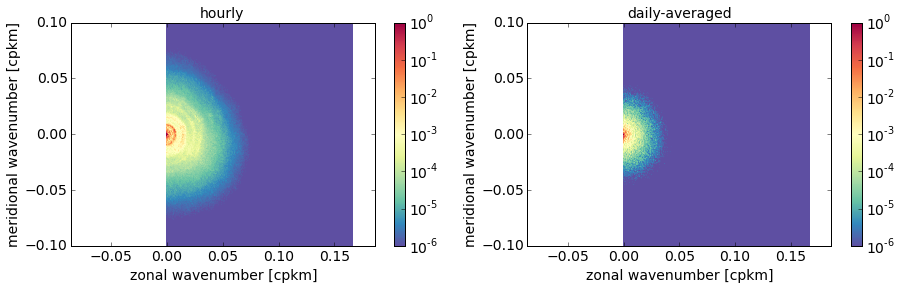

In [42]:
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.pcolormesh(spec_wv['k'][nk/2:],spec_wv['l'],
               spec_wv['Eeta'],norm = LogNorm())

plt.clim([1.e-6,1.e0])

plt.colorbar()

plt.axis('equal')

plt.xlim(0,.1)
plt.ylim(-.1,.1)

plt.xlabel('zonal wavenumber [cpkm]')
plt.ylabel('meridional wavenumber [cpkm]')
plt.title('hourly')

plt.subplot(122)
plt.pcolormesh(spec_wv['k'][nk/2:],spec_wv['l'],
               spec_wv['Eetad'].squeeze(),norm = LogNorm())

plt.clim([1.e-6,1.e0])
plt.axis('equal')

plt.xlim(0,.1)
plt.ylim(-.1,.1)

plt.xlabel('zonal wavenumber [cpkm]')
plt.ylabel('meridional wavenumber [cpkm]')
plt.title('daily-averaged')

plt.colorbar()

In [43]:
kr, Er = spec.calc_ispec(spec_wv['k'][nk/2:],spec_wv['l'],spec_wv['Eeta'])
_, Edr = spec.calc_ispec(spec_wv['k'][nk/2:],spec_wv['l'],spec_wv['Eetad'].squeeze())

In [44]:
sn  = 10*np.ones(Er.size)

In [45]:
Erl,Eru = spec.spec_error(Er, sn, ci=0.95)  
Edrl,Edru = spec.spec_error(Edr, sn, ci=0.95)  

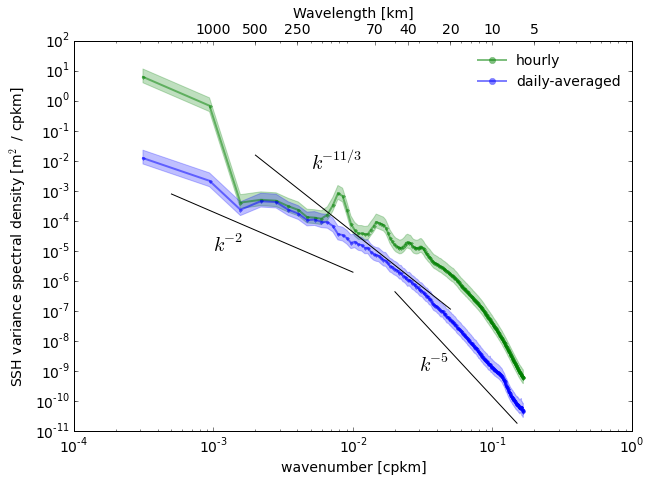

In [46]:
ki = np.array([5.e-4,1.e-2])
ki2 = np.array([2.e-2,1.5e-1])
ki3 = np.array([2.e-3,5.e-2])

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)

ax1.fill_between(kr,Erl,Eru, color='g', alpha=0.25)
ax1.fill_between(kr,Edrl,Edru, color='b', alpha=0.25)
ax1.loglog(kr,Er,'g.-',linewidth=2.,alpha=.5,label='hourly')
ax1.loglog(kr,Edr,'b.-',linewidth=2.,alpha=.5,label='daily-averaged')

ax1.loglog(ki,ki**-2./5.e9,'k')
ax1.text(1.e-3,1.e-5,r'$k^{-2}$',fontsize=20)
ax1.loglog(ki2,ki2**-5/7.e14,'k')
ax1.text(3.e-2,1.e-9,r'$k^{-5}$',fontsize=20)

ax1.loglog(ki3,ki3**(-11/3.)/5.e11,'k')
ax1.text(5.e-3,.5e-2,r'$k^{-11/3}$',fontsize=20)

plt.xlabel('wavenumber [cpkm]')
plt.ylabel(r'SSH variance spectral density [m$^2$ / cpkm]')

plt.legend()

TPtools.add_second_axis(ax1)

# How does the daily-averaged spectrum compare with previous estimates?

Here's Xu $\&$ Fu JPO 2012 figure showing the global distribution of (negative of) spectral slopes in the $70-250$ km range. It is hard know accurately but it appears the the slopes in the Tropical Pacific vary from 1.4 and 2.

In [47]:
from IPython.display import Image

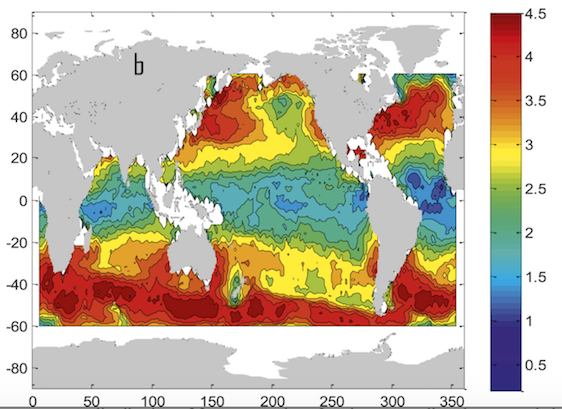

In [48]:
Image(filename='../figs/XuFu2012.png')

Estimating the slopes in the same subrange, we obtain

In [49]:
slope_est, slope_error = spec.spectral_slope(kr,Edr,1./250,1./70,stdE=1./np.sqrt(sn.mean()))

In [50]:
print("The spectral slope of the daily-average SSH variance spectrum between 70-250 km is ", slope_est[0])

The spectral slope of the daily-average SSH variance spectrum between 70-250 km is  -2.52944860592


# One dimensional spectra

We now calculate one-dimensional wavenumber spectra of zonal and meridional transects.

In [124]:
ssh_spec_lats = np.load('eta_wavenumber_lats.npz')
ke_spec_lats = np.load('uv_wavenumber_lats.npz')

In [135]:
def set_spec_axis(var='eta',dir='zonal'):
    plt.xlabel(dir+' wavenumber [cpkm]')
    if var == 'eta':
        plt.ylabel(r'SSH variance density [m$^2$/cpkm]')
    elif var == 'ke':
        plt.ylabel(r'KE density [m$^2$ s$^{-2}$/cpkm]')


        
    plt.xlim(5.e-4,1./6.)
    plt.ylim(1.e-9,1.e0)
    
def plt_spec_slopes(kmin=1./800,kmax=1./5,power=-11/3.,
                    scaling=1.e-12,xtext=1./600.,ytext=1./25.,text=r'-11/3'):
    
    k = np.array([kmin,kmax])
    plt.loglog(k,scaling*(k**power),'-',color="0.5",linewidth=2.)
    plt.text(xtext,ytext,text,fontsize=14)
    
def plt_spec_error(x=0.034,y=0.15, sn=200):
    Erl, Eru = spec.spec_error(y,sn=sn)

    try:
        nx = sn.size
        err=np.array(np.vstack([y-Erl,Eru-y]))        
        plt.errorbar(x, y, yerr=err.squeeze(), color='k',fmt='.')
        plt.text(x[0]-0.001,y[0],r'95 $\%$',fontsize=15)
    except: 
        err=np.array(np.vstack([y-Erl,Eru-y]))[...,np.newaxis]        
        plt.errorbar(x, y, yerr=err, color='k',fmt='.')
        plt.text(x+0.003,y-1.e-3,r'95 $\%$',fontsize=14)

## SSH spectra

As for the two-dimensional, and azimuthally-averaged spectra, the one-dimensional SHH variance spectrum is relatively shallow. Daily-averaging the fields supresses significant high-wavenumber variability at scales smaller than about 400 km. The spectrum of daily-averaged SSH is steeper than that of hourly SSH fields, but still much shallower than the spectra in Drake Passage.

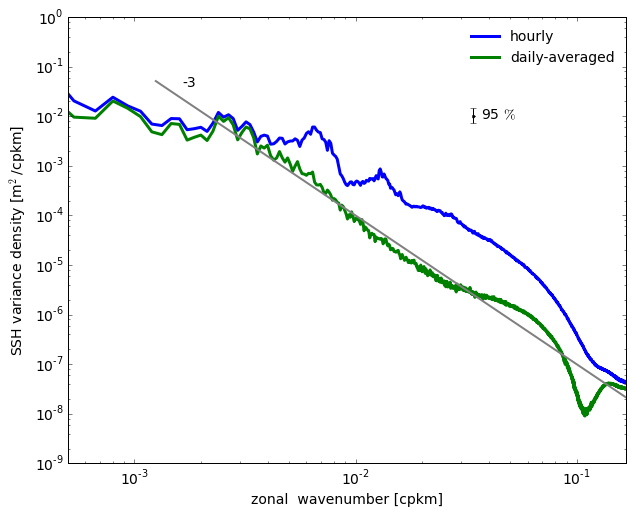

In [162]:
plt.figure(figsize=(10,8))

plt.loglog(spec_lats['k'],ssh_spec_lats['Eeta'][::2,:].mean(axis=0),
           linewidth=3., label='hourly')
plt.loglog(spec_lats['k'],ssh_spec_lats['Eetad'][::2,:].mean(axis=0),
           linewidth=3., label='daily-averaged')
set_spec_axis(dir='zonal ')
plt_spec_slopes(power=-3,scaling=1.e-10,text='-3')


plt_spec_error(y=0.01,sn=25)

plt.legend()

## Surface KE spectra

The surface KE spectra is shows significant presence of horizontally divergent flows at scales as large as 500 km. Recall that the two-dimensional spectra is fairly isotropic, so for horizontally non-divergent flows we would expect the across-track spectrum to dominate the along-track spectrum (the opposite is true for horizontally divergent flows). Daily-averaging the velocities significantly supresses high-wavenumber variability. The spectra of daily-averaged flows has characteristics of horizontally isotropic, non-divergent flows. 

(1e-05, 1.0)

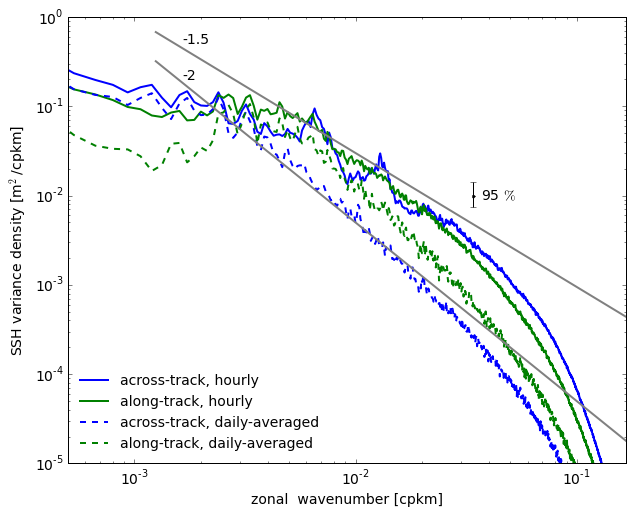

In [164]:
plt.figure(figsize=(10,8))

plt.loglog(spec_lats['k'],ke_spec_lats['Eu'][::2,:].mean(axis=0),
           linewidth=2., label='across-track, hourly',color='b')
plt.loglog(spec_lats['k'],ke_spec_lats['Ev'][::2,:].mean(axis=0),
           linewidth=2., label='along-track, hourly',color='g')
plt.loglog(spec_lats['k'],ke_spec_lats['Eud'][::2,:].mean(axis=0),'--',
           linewidth=2., label='across-track, daily-averaged',color='b')
plt.loglog(spec_lats['k'],ke_spec_lats['Evd'][::2,:].mean(axis=0),'--',
           linewidth=2., label='along-track, daily-averaged',color='g')

set_spec_axis(dir='zonal ')
plt_spec_slopes(power=-2.,scaling=5.e-7,text='-2',ytext=0.2)
plt_spec_slopes(power=-1.5, scaling=3.e-5,text='-1.5',ytext=.5)


plt_spec_error(y=0.01,sn=25)

plt.legend(loc=3)
plt.ylim(1.e-5,1.)